In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

In [3]:
# Read csv files into pandas frames 
uos_data = pd.read_csv('../Preprocessed_Data/analysis_data_Osnabrück.csv')
utwente_data = pd.read_csv('../Preprocessed_Data/analysis_data_Enschede.csv')

uos_data['timestamp_start'] = pd.to_datetime(uos_data['timestamp_start'])
utwente_data['timestamp_start'] = pd.to_datetime(utwente_data['timestamp_start'])

uos_data = uos_data.sort_values(by='timestamp_start')
utwente_data = utwente_data.sort_values(by='timestamp_start')

# drop NA values
uos_data = uos_data.replace([np.inf, -np.inf], np.nan).dropna()
utwente_data = utwente_data.replace([np.inf, -np.inf], np.nan).dropna()
# drop wrong weather measurements
uos_data.drop(uos_data[uos_data['windspeed'] < 0].index, inplace=True)
utwente_data.drop(utwente_data[utwente_data['windspeed'] < 0].index, inplace=True)
# Create rain buckets for analysis
for i in range(0,7):
    uos_data.loc[uos_data['rain'] > i-1, 'bucket'] = i

for i in range(0,7):
    utwente_data.loc[utwente_data['rain'] > i-1, 'bucket'] = i

# Print amount of samples per bucket
print('### Samples per bucket before cleaning:')
print(uos_data['bucket'].value_counts())
print(utwente_data['bucket'].value_counts())

# Remove outliers
def remove_outliers(bucket_df):
    Q1 = bucket_df['download'].quantile(0.25)
    Q3 = bucket_df['download'].quantile(0.75)
    IQR = Q3 - Q1
    # Filtere die Daten ohne Ausreißer
    no_outliers = bucket_df[(bucket_df['download'] >= Q1 - 1.5 * IQR) & (bucket_df['download'] <= Q3 + 1.5 * IQR)]
    return no_outliers

# Gruppiere nach 'bucket' und wende die Funktion auf jede Gruppe an
uos_data = uos_data.groupby('bucket').apply(remove_outliers).reset_index(drop=True)
utwente_data = utwente_data.groupby('bucket').apply(remove_outliers).reset_index(drop=True)

print('### Samples per bucket after cleaning:')
# Print amount of samples per bucket
print(uos_data['bucket'].value_counts())
print(utwente_data['bucket'].value_counts())

### Samples per bucket before cleaning:
0.0    53038
1.0     4008
2.0     1213
3.0      433
6.0      229
4.0      209
5.0       89
Name: bucket, dtype: int64
0.0    25516
1.0     2624
2.0      685
3.0      183
4.0       54
6.0       43
5.0       29
Name: bucket, dtype: int64
### Samples per bucket after cleaning:
0.0    52420
1.0     4000
2.0     1201
3.0      432
6.0      229
4.0      207
5.0       88
Name: bucket, dtype: int64
0.0    25210
1.0     2601
2.0      679
3.0      181
4.0       52
6.0       42
5.0       27
Name: bucket, dtype: int64


[[0, -9.240866666666648], [1, -13.139933333333317], [2, -12.790133333333301], [3, -17.06966666666665], [4, -20.548166666666617], [5, -28.151433333333273], [6, -14.992700000000013], [7, -6.8197999999999865], [8, -5.274933333333308], [9, -7.0581666666666365], [10, -2.710333333333324], [11, -1.2494333333333145], [12, 0.45596666666668284], [13, 1.5121333333333382], [14, 2.263433333333353], [15, 4.3631666666667], [16, 10.019833333333366], [17, 19.800600000000003], [18, 26.23303333333334], [19, 33.92830000000001], [20, 34.545966666666686], [21, 22.629866666666686], [22, 6.929033333333365], [23, -0.903366666666642]]


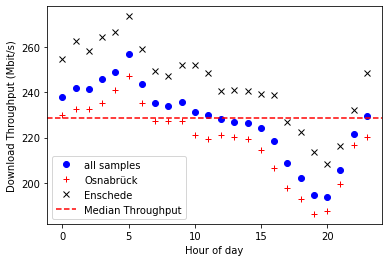

In [4]:
# BW Analyse pro Stunde ohne Regen
joined_df = pd.concat([uos_data, utwente_data])

# remove inf nan and pepare fields
joined_df['download_mbps'] = joined_df['download'] / 1_000_000
uos_data['download_mbps'] = uos_data['download'] / 1_000_000
utwente_data['download_mbps'] = utwente_data['download'] / 1_000_000
joined_df['timestamp_start'] = pd.to_datetime(joined_df['timestamp_start'])


hour_vs_bw = []
for i in range(0,24):    
    filtered_data = joined_df[(joined_df['timestamp_start'].dt.hour == i) & (joined_df['timestamp_start'].dt.hour < i+1) & (joined_df['bucket'] == 0)]
    length = str(len(filtered_data))
    hour_vs_bw.append([i, filtered_data['download_mbps'].median()])
stunden, bandbreiten = zip(*hour_vs_bw)

hour_vs_bw_uos = []
for i in range(0,24):    
    filtered_data = uos_data[(uos_data['timestamp_start'].dt.hour == i) & (uos_data['timestamp_start'].dt.hour < i+1) & (uos_data['bucket'] == 0)]
    length = str(len(filtered_data))
    hour_vs_bw_uos.append([i, filtered_data['download_mbps'].median()])
stunden_uos, bandbreiten_uos = zip(*hour_vs_bw_uos)

hour_vs_bw_twente = []
for i in range(0,24):    
    filtered_data = utwente_data[(utwente_data['timestamp_start'].dt.hour == i) & (utwente_data['timestamp_start'].dt.hour < i+1) & (utwente_data['bucket'] == 0)]
    length = str(len(filtered_data))
    hour_vs_bw_twente.append([i, filtered_data['download_mbps'].median()])
stunden_twente, bandbreiten_twente = zip(*hour_vs_bw_twente)


# Line Plot erstellen
plt.plot(stunden, bandbreiten, marker='o', linestyle='', color='b', label='all samples')
plt.plot(stunden_uos, bandbreiten_uos, marker='+', linestyle='', color='r', label='Osnabrück')
plt.plot(stunden_twente, bandbreiten_twente, marker='x', linestyle='', color='k', label='Enschede')

# Median über alle Bandbreiten berechnen
median_bandbreite = joined_df[joined_df['bucket'] == 0]['download_mbps'].median()

# Median als horizontale Linie im Diagramm hinzufügen
plt.axhline(y=median_bandbreite, color='r', linestyle='--', label='Median Throughput')

# Achsentitel und Diagrammtitel hinzufügen
plt.xlabel('Hour of day')
plt.ylabel('Download Throughput (Mbit/s)')
#plt.title('Median Throughput per hour (both sites, without rain)')

# Legende hinzufügen
plt.legend()

plt.savefig('../Plots/Fig10.pdf')
# Diagramm anzeigen
#plt.show()

# get correction factor per hour
median_bw = joined_df[joined_df['bucket'] == 0]['download_mbps'].median()
correction_factors = []

for item in hour_vs_bw:
    corr_f = median_bw - item[1]
    correction_factors.append([item[0], corr_f])
print(correction_factors)

pd.DataFrame(correction_factors).to_csv('correction_factors.csv', index=False)

# apply correction factors
for item in correction_factors:
    condition = joined_df['timestamp_start'].dt.hour == item[0]
    joined_df.loc[condition, 'download_mbps'] += item[1]

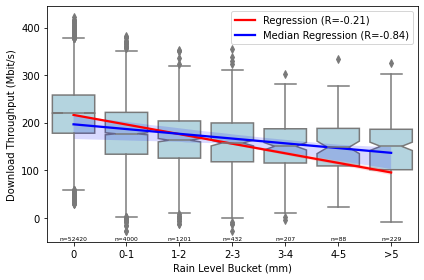

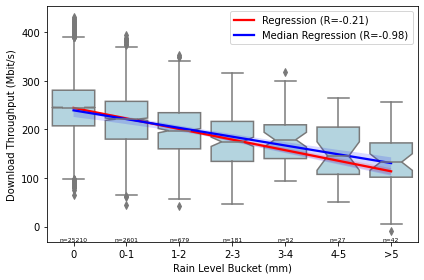

In [5]:
#get medians 
# Berechne den Median für jede Gruppe in der Spalte 'bucket'
uos_df = joined_df[joined_df['site_name'] == 'uos-rz']
medians_uos = uos_df.groupby('bucket')['download_mbps'].median()

# Erstelle eine DataFrame mit den Medians
medians_uos_df = pd.DataFrame({'bucket': medians_uos.index, 'median_download_mbps': medians_uos.values})

# Subplot für uos_data
fig, ax = plt.subplots(figsize=(6, 4))

# Plot für uos_data
sns.boxplot(x='bucket', y='download_mbps', data=uos_df, notch=True, color='lightblue', ax=ax)
r_uos = pearsonr(uos_df['bucket'], uos_df['download_mbps'])[0]
r_uos_median = pearsonr(medians_uos_df['bucket'], medians_uos_df['median_download_mbps'])[0]
sns.regplot(x='bucket', y='download_mbps', data=uos_df, scatter=False, color='red', ci=95, ax=ax, label=f'Regression (R={r_uos:.2f})')
sns.regplot(x='bucket', y='median_download_mbps', data=medians_uos_df, scatter=False, color='blue', ci=95, ax=ax, label=f'Median Regression (R={r_uos_median:.2f})')
ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('Rain Level Bucket (mm)')
ax.set_ylabel('Download Throughput (Mbit/s)')

# Manuelle x-Ticklabels und Sample Counts für uos_data
bucket_labels_uos = ['0', '0-1', '1-2', '2-3', '3-4', '4-5', '>5']
sample_counts_uos = uos_df['bucket'].value_counts().sort_index()
ax.set_xticklabels(bucket_labels_uos)
for i, count in enumerate(sample_counts_uos):
    ax.text(i, -45, f'n={count}', ha='center', va='center', color='black', fontsize=6)

# Legende für die rote Regressionslinie mit R-Wert
ax.legend()

plt.tight_layout()
plt.savefig('../Plots/Fig11a.pdf')
#plt.show()


# Subplot für utwente_data
fig, ax = plt.subplots(figsize=(6, 4))

# Berechne den Median für jede Gruppe in der Spalte 'bucket'
utwente_df = joined_df[joined_df['site_name'] == 'utwente']
medians_utwente = utwente_df.groupby('bucket')['download_mbps'].median()

# Erstelle eine DataFrame mit den Medians
medians_utwente_df = pd.DataFrame({'bucket': medians_utwente.index, 'median_download_mbps': medians_utwente.values})

# Plot für utwente_data
sns.boxplot(x='bucket', y='download_mbps', data=utwente_df, notch=True, color='lightblue', ax=ax)
r_utwente = pearsonr(utwente_df['bucket'], utwente_df['download_mbps'])[0]
r_utwente_median = pearsonr(medians_utwente_df['bucket'], medians_utwente_df['median_download_mbps'])[0]
sns.regplot(x='bucket', y='download_mbps', data=utwente_df, scatter=False, color='red', ci=95, ax=ax, label=f'Regression (R={r_utwente:.2f})')
sns.regplot(x='bucket', y='median_download_mbps', data=medians_utwente_df, scatter=False, color='blue', ci=95, ax=ax, label=f'Median Regression (R={r_utwente_median:.2f})')
ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('Rain Level Bucket (mm)')
ax.set_ylabel('Download Throughput (Mbit/s)')

# Manuelle x-Ticklabels und Sample Counts für utwente_data
bucket_labels_utwente = ['0', '0-1', '1-2', '2-3', '3-4', '4-5', '>5']
sample_counts_utwente = utwente_df['bucket'].value_counts().sort_index()
ax.set_xticklabels(bucket_labels_utwente)
for i, count in enumerate(sample_counts_utwente):
    ax.text(i, -26, f'n={count}', ha='center', va='center', color='black', fontsize=6)

# Legende für die rote Regressionslinie mit R-Wert
ax.legend()

plt.tight_layout()
plt.savefig('../Plots/Fig11b.pdf')
#plt.show()

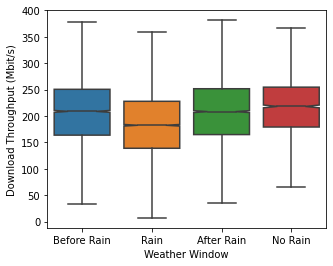

In [6]:
# Rain Window Analysis
all_rain_wdw = []
all_before_rain_wdw = []
all_after_rain_wdw = []
# key 31 = download_mbps
# key 30 = bucket
# key 26 = rain
# key 33 = datetime
# key 1 = timestamp orig (start)

index_bucket = joined_df.columns.get_loc('bucket')
index_download_mbps = joined_df.columns.get_loc('download_mbps')


df_sorted_uos = joined_df[joined_df['site_name'] == 'uos-rz'].sort_values(by='timestamp_start')
df_sorted_utwente = joined_df[joined_df['site_name'] == 'utwente'].sort_values(by='timestamp_start')
joined_df_sorted = pd.concat([df_sorted_uos, df_sorted_utwente])

rain_flag = 0
rain_start = 0
rain_stop = 0
curr_rain_wdw = []
rain_indexes = []

for i, item in enumerate(joined_df_sorted.values):
    if rain_flag == 0:
        if item[index_bucket] > 0: 
            rain_start = i
            rain_flag = 1
            curr_rain_wdw.append(item)
            all_before_rain_wdw.append([i-4,i])
        else:
            continue
    elif rain_flag == 1:
        if item[index_bucket] > 0:
            rain_stop = i            
            curr_rain_wdw.append(item)
        elif item[index_bucket] == 0:
            rain_flag = 0
            all_rain_wdw.append(curr_rain_wdw)
            all_after_rain_wdw.append([i,i+4])
            rain_indexes.append([rain_start, rain_stop])
            curr_rain_wdw = []

values = joined_df_sorted['download_mbps'].values
all_before_rain_wdw_res = []
all_after_rain_wdw_res = []
all_rain_wdw_res = []
for item in all_before_rain_wdw:
    all_before_rain_wdw_res.append(values[item[0]:item[1]])

for item in all_after_rain_wdw:
    all_after_rain_wdw_res.append(values[item[0]:item[1]])

for item in rain_indexes:
    all_rain_wdw_res.append(values[item[0]:item[1]])


no_rain_samples = joined_df_sorted[(joined_df_sorted['bucket'] == 0) &(joined_df_sorted['solarradiation'] > 300)]['download_mbps'] 

# Kombiniere alle Zahlen zu flachen Listen für jeden Datensatz
flattened_data_rain = [val for sublist in all_rain_wdw_res for val in sublist]
flattened_data_after_rain = [val for sublist in all_after_rain_wdw_res for val in sublist]
flattened_data_before_rain = [val for sublist in all_before_rain_wdw_res for val in sublist]

# Erstelle DataFrame für Seaborn
data = pd.DataFrame({'DL Throughput': flattened_data_rain + flattened_data_after_rain + flattened_data_before_rain + no_rain_samples.to_list(),
                     'Window': ['Rain']*len(flattened_data_rain) + ['After Rain']*len(flattened_data_after_rain) + ['Before Rain']*len(flattened_data_before_rain) + ['No Rain']*len(no_rain_samples.to_list())})

# Ändere die Reihenfolge der Fenster
window_order = ['Before Rain', 'Rain', 'After Rain', 'No Rain']

# Erstelle Boxplot mit Seaborn und aktiviere Notches
plt.figure(figsize=(5, 4))
sns.boxplot(x='Window', y='DL Throughput', data=data, showfliers=False, order=window_order, notch=True)
plt.ylabel('Download Throughput (Mbit/s)')
plt.xlabel('Weather Window')
plt.savefig('../Plots/Fig12.pdf')
plt.show()

In [267]:
utwente_data.groupby('bucket')['download_mbps'].median()

bucket
0.0    245.417000
1.0    222.168200
2.0    197.775533
3.0    172.041267
4.0    173.953733
5.0    135.423800
6.0    127.538300
Name: download_mbps, dtype: float64

In [8]:
data.groupby('Window').median()

,DL Throughput
Window,
After Rain,208.285467
Before Rain,208.706000
No Rain,218.121383
Rain,182.434283


In [7]:
import numpy as np, scipy.stats as st


for item in data['Window'].unique():
    print(item)
    cid = st.t.interval(0.95, len(data[data['Window'] == item]['DL Throughput'])-1, loc=np.median(data[data['Window'] == item]['DL Throughput']), scale=st.sem(data[data['Window'] == item]['DL Throughput']))
    print(cid)

Rain
(181.03325822983945, 183.83530843682726)
After Rain
(206.58655842194605, 209.98437491138725)
Before Rain
(207.02757934778643, 210.38442065221355)
No Rain
(215.6223727021658, 220.6203939645009)
